# BPE and Tokenization assignment

This notebook demonstrates:
- Applying BPE on text in English, French, Spanish, and German.
- Computing compression ratios for each language using BPE.
- Computing compression ratios using the GPT tiktoken library and comparing
- Computing the effect of vocabulary size on compression ratio for English, French, Spanish and German.
- Analyzing the effect of file size on the compression ratio for English text.





```
Make use of LLMs like ChatGPT and Claude to help you with code!

You can give a good, detailed prompt and get code for plotting, varying file sizes etc.

Make sure to use the codes we discussed in class also.
```



##Step 1: Install necessary packages
You might need tiktoken and matplotlib


##Step 2: Write BPE code which takes a text file, performs BPE and finds compression ratio.

- You can use the code we discussed in class.

- The dataset files for all languages (English, French, German and Spanish) have been provided to you.

- Note that you can consider the final vocabulary size you can consider = Original vocabulary size  + 200 extra tokens.

In [29]:
# all functions in one place.
import matplotlib.pyplot as plt
def get_character_tokens(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    char_tokens = [ord(ch) for ch in text]
    ids = list(char_tokens)
    max_id = max(ids)
    return ids, max_id

def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
    newids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

def merg_token_ids(token_ids,num_merges, max_id):
    for i in range(num_merges):
        # 1) Count all adjacent pairs in our current sequence 'ids'.
        stats = get_stats(token_ids)
        pair = max(stats, key=stats.get)
        idx = max_id + i
        # Decode the characters of the pair for display
        char_pair = (chr(pair[0]), chr(pair[1]))
        token_ids = merge(token_ids, pair, idx)
    return token_ids

def print_compression_ratio(language, char_tokens_ids, merged_token_ids):
    comp_ratio = len(char_tokens_ids) / len(merged_token_ids)
    print(f"{language} char tokens length: {len(char_tokens_ids)}")
    print(f"{language} merged token ids length: {len(merged_token_ids)}")
    print(f"{language} compression ratio: {comp_ratio:.4f}X")
    print("......................................\n")
    return comp_ratio

def draw_bar_graph(labels, values, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    

English char tokens length: 1115394
English merged token ids length: 773537
English compression ratio: 1.4419X
......................................

French char tokens length: 1244159
French merged token ids length: 846563
French compression ratio: 1.4697X
......................................

German char tokens length: 1284261
German merged token ids length: 844373
German compression ratio: 1.5210X
......................................

Spanish char tokens length: 1172872
Spanish merged token ids length: 787665
Spanish compression ratio: 1.4890X
......................................



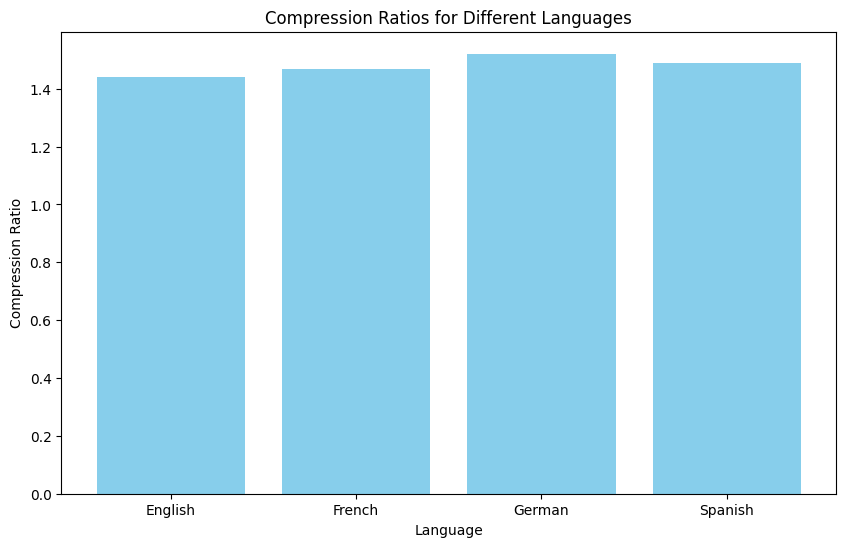

In [ ]:
lang = ["English", "French", "German", "Spanish"]
files = ["./input.txt", "./output_french.txt", "./output_german.txt", "./output_spanish.txt"]
comp_ratios = []
for i in range(0, len(lang)):
    ids, max_id = get_character_tokens(files[i])
    ids_merged = merg_token_ids(ids, 200, max_id)
    comp_ratios.append(print_compression_ratio(lang[i], ids, ids_merged))

draw_bar_graph(lang, comp_ratios, 'Compression Ratios for Different Languages', 'Language', 'Compression Ratio')

##Step 3: Make bar plot of compression ratio for the 4 languages: English, French, German and Spanish.

In [ ]:
## Your code here. Feel free to use ChatGPT, Claude for help.

##Step 4: Use tiktoken library and use tokenization schemes for GPT-2, GPT-3.5 and GPT-4. Find compression ratio for all 4 languages.

- You can use the tiktoken code we have seen in class.

In [ ]:
## Your code here. Feel free to use ChatGPT, Claude for help.

## Step 5: Make bar plots to compare compression ratios for BPE, GPT-2, GPT-3.5 and GPT-4 for all 4 languages

In [ ]:
## Your code here. Feel free to use ChatGPT, Claude for help.

## Step 6: Vary the extra tokens from 200 to 500 to 800. Write code to find effect of extra tokens on the compression ratio. Do this for all languages

Hint: You already have written the BPE code for extra tokens = 200 in Step 2. Use this as reference.

In [ ]:
## Your code here. Feel free to use ChatGPT, Claude for help.

## Step 7: Write code for varying input file size and see effect on compression ratio (only for English language).

- Create text files with decreasing sizes using the scaling factors: 10, 8, 6.

- Note that the final vocabulary size you can consider = Original vocabulary size + 5% of the total text size.

Hint: Here is how you can use scaling factor of let's say 10.


```
fraction = 1 / 10

subtext = input_text[:int(len_text * fraction)]
```



In [ ]:
## Your code here. Feel free to use ChatGPT, Claude for help.